In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

For detailed comments about the code look at the first quarter analysis

# Fourth quarter

First all the products are aggregated per category, taking as price of the category the mean of the log(price_changes) 

In [4]:
pdfourth = pd.read_csv('dataset/fourth_quarter.csv', index_col=0)

In [5]:
pdfourth

,comp_date,seller_id,seller_name,product_id,price,min(price),max(price),coded_cat1,coded_cat2,coded_cat3,coded_brand,price_change,price_change_log,price_change_var
0,2021-10-01,23,C,100204,649,467,667,1163,1267,4325,445,NaN,NaN,376.923077
1,2021-10-01,23,C,100205,799,723,930,1163,1267,4325,445,NaN,NaN,376.923077
2,2021-10-01,23,C,100212,1299,1283,1832,1163,1267,4325,445,NaN,NaN,9423.076923
3,2021-10-01,23,C,100404,1299,1095,1590,1375,1760,1410,279,NaN,NaN,192.307692
5,2021-10-01,23,C,100406,2699,1769,2699,1375,1760,1410,279,NaN,NaN,20007.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910951,2021-12-31,490,L,183301,2499,1490,2499,2180,613,2275,392,0.0,0.0,NaN
1910953,2021-12-31,490,L,183364,24990,18990,26290,1676,2832,1273,775,0.0,0.0,624333.511111
1910955,2021-12-31,490,L,183943,2149,1599,2999,2180,613,2275,681,0.0,0.0,6698.240166
1910956,2021-12-31,490,L,183944,1429,1199,1790,2180,613,2275,360,0.0,0.0,2070.000000


In [6]:
ge=pdfourth.groupby(['comp_date','seller_id','coded_cat1'])['price_change_log'].mean().reset_index()
ge['comp_date'] = pd.to_datetime(ge['comp_date'])

pivot={}
for i in pdfourth['coded_cat1'].unique():
    pivot[i] = ge[ge['coded_cat1']==i].pivot(index='comp_date', columns='seller_id', values='price_change_log')

for i in pdfourth['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = pivot[i]

Dropping all the seller that have all null values for a specific category

In [7]:
c=0
for i in pdfourth['coded_cat1'].unique():
    for j in globals()['pivot{}'.format(i)].columns:
        if np.isnan(globals()['pivot{}'.format(i)][j]).all() == True or (globals()['pivot{}'.format(i)][j]).sum() == 0:
            print(f'for the seller {j} the category {i} has all null values or zeros, so we drop it')
            globals()['pivot{}'.format(i)].drop(j, inplace=True, axis=1)
        else:
            c += 1

if c == 107:
    print('None of the category has all null values for each of sellers')

None of the category has all null values for each of sellers


In [8]:
#fill na in all the pivot 
for i in pdfourth['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(method='ffill')
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(method='bfill')
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(0)

## Pivot 1163

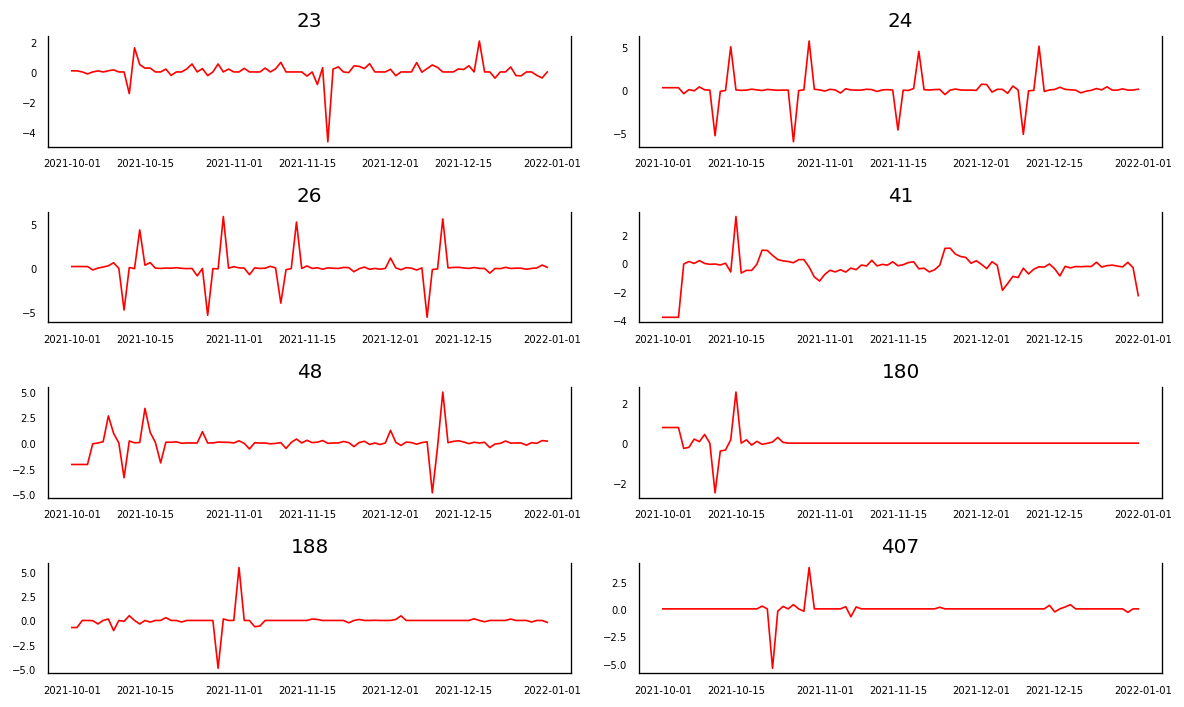

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1163[pivot1163.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot1163.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [12]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.2716
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.226
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [13]:
pivot1163 = pivot1163.diff().dropna()

In [14]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [15]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.3087
 No. Lags Chosen       = 2
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.0461
 No. Lags Chosen       = 9
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [16]:
cointegration_test(pivot1163)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  563.74    > 179.5199  =>   True
24     ::  406.6     > 143.6691  =>   True
26     ::  282.88    > 111.7797  =>   True
41     ::  203.17    > 83.9383   =>   True
48     ::  133.0     > 60.0627   =>   True
180    ::  77.54     > 40.1749   =>   True
188    ::  51.04     > 24.2761   =>   True
407    ::  25.67     > 12.3212   =>   True
490    ::  10.88     > 4.1296    =>   True


In [17]:
#VAR model on df_pivot
model = VAR(pivot1163)
x = model.select_order(maxlags=8)
x.summary()

,AIC,BIC,FPE,HQIC
0,1.543,1.805,4.677,1.648
1,0.3098,2.933,1.378,1.363
2,-0.7284,4.255,0.5199,1.274
3,-1.272,6.072,0.3590,1.678
4,-1.870,7.835,0.2824,2.029
5,-3.359,8.706,0.1231,1.488
6,-6.744,7.682,0.01336,-0.9482
7,-14.36,2.429,5.422e-05,-7.613
8,-30.72*,-11.58*,3.304e-10*,-23.03*


In [18]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:12:46
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -11.5782
Nobs:                     83.0000    HQIC:                  -23.0329
Log likelihood:           872.138    FPE:                3.30363e-10
AIC:                     -30.7249    Det(Omega_mle):     1.12869e-12
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.000099         0.040207           -0.002           0.998
L1.23         -0.752720         0.226482           -3.324           0.001
L1.24          0.036263         0.189508            0.191           0.848
L1.26         -0.

# PIVOT 1375

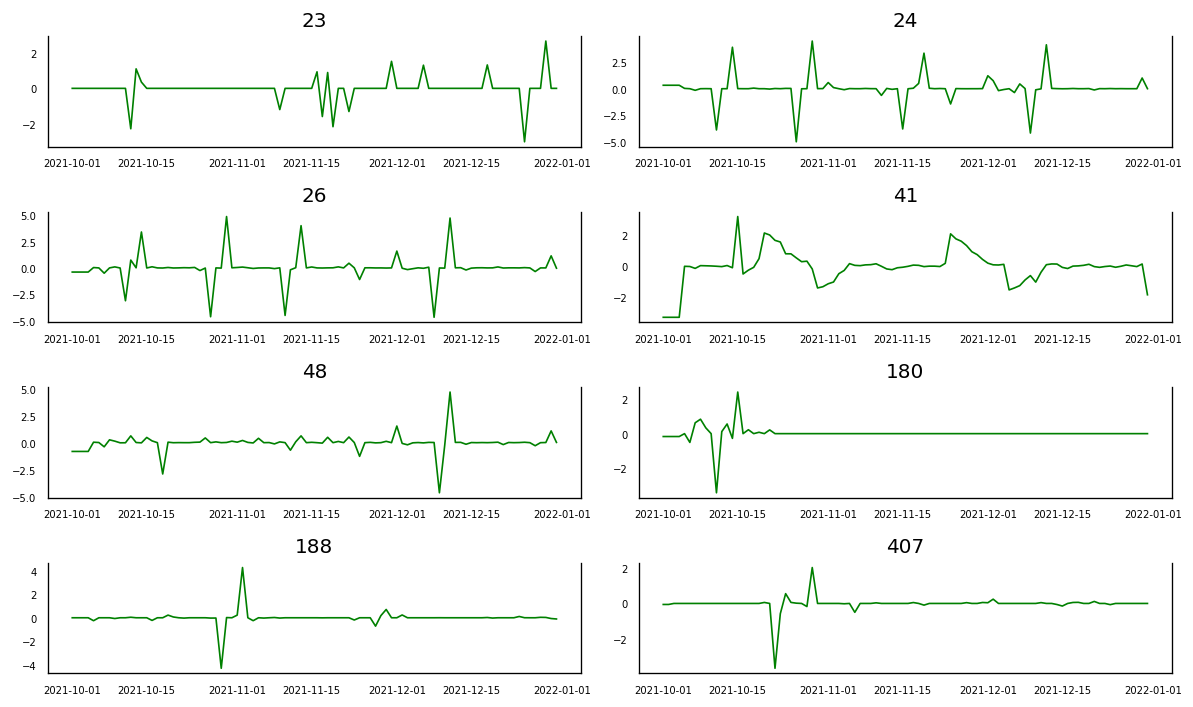

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1375[pivot1375.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1375.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [20]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.55
 No. Lags Chosen       = 3
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8954
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [21]:
pivot1375 = pivot1375.diff().dropna()

In [22]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3037
 No. Lags Chosen       = 8
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6591
 No. Lags Chosen       = 8
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [23]:
cointegration_test(pivot1375)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  555.67    > 179.5199  =>   True
24     ::  412.48    > 143.6691  =>   True
26     ::  309.68    > 111.7797  =>   True
41     ::  210.9     > 83.9383   =>   True
48     ::  140.39    > 60.0627   =>   True
180    ::  93.47     > 40.1749   =>   True
188    ::  61.47     > 24.2761   =>   True
407    ::  35.64     > 12.3212   =>   True
490    ::  11.78     > 4.1296    =>   True


In [24]:

#VAR model on df_pivot
model = VAR(pivot1375)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,-0.5729,-0.3107,0.5639,-0.4676
1,-2.063,0.5601,0.1285,-1.009
2,-2.673,2.311,0.07441,-0.6705
3,-2.772,4.571,0.08006,0.1779
4,-3.236,6.469,0.07208,0.6631
5,-4.565,7.500,0.03684,0.2817
6,-7.499,6.926,0.006272,-1.704
7,-13.06,3.728,0.0001987,-6.314
8,-30.33*,-11.18*,4.920e-10*,-22.63*


In [25]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:12:53
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -11.1798
Nobs:                     83.0000    HQIC:                  -22.6345
Log likelihood:           855.605    FPE:                4.92047e-10
AIC:                     -30.3266    Det(Omega_mle):     1.68108e-12
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.015739         0.119041           -0.132           0.895
L1.23         -0.555308         0.303143           -1.832           0.067
L1.24          0.215450         0.306755            0.702           0.482
L1.26         -0.

# PIVOT 2180

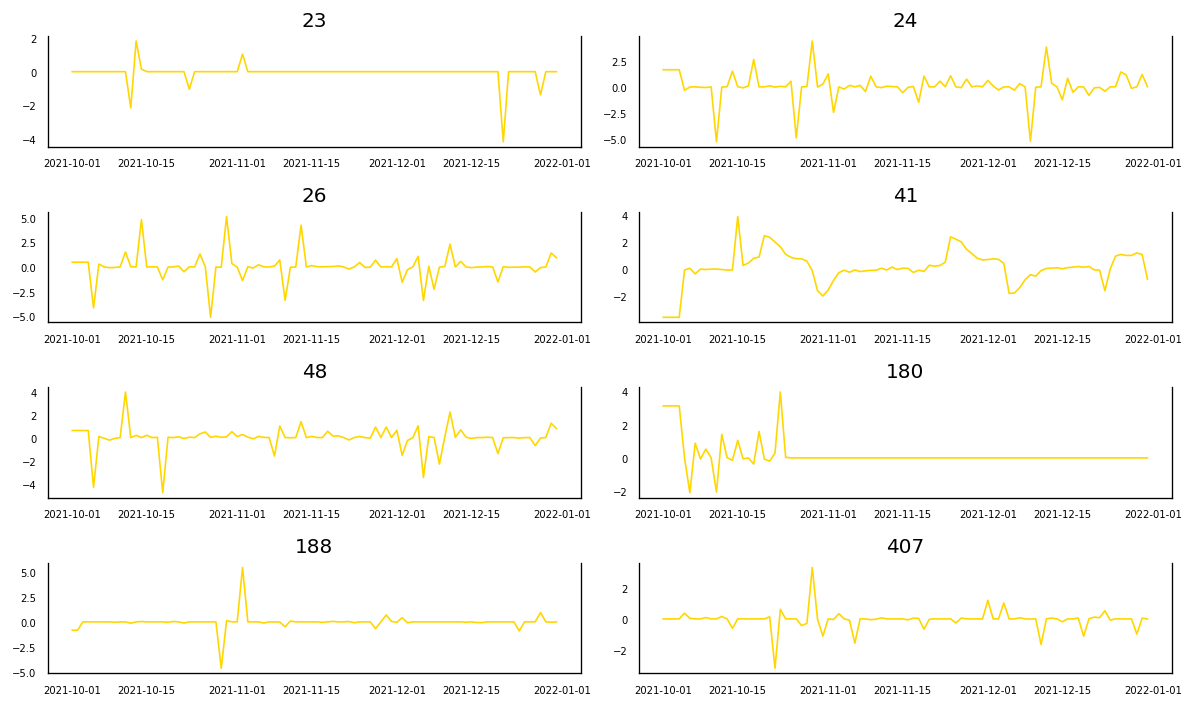

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2180[pivot2180.columns[i]]
    ax.plot(data, color='gold', linewidth=1)
    # Decorations
    ax.set_title(pivot2180.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.8386
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1901
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [28]:
pivot2180 = pivot2180.diff().dropna()

In [29]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7414
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3475
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [30]:
cointegration_test(pivot2180)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  540.12    > 179.5199  =>   True
24     ::  390.91    > 143.6691  =>   True
26     ::  302.06    > 111.7797  =>   True
41     ::  227.21    > 83.9383   =>   True
48     ::  165.8     > 60.0627   =>   True
180    ::  106.27    > 40.1749   =>   True
188    ::  62.46     > 24.2761   =>   True
407    ::  31.61     > 12.3212   =>   True
490    ::  8.08      > 4.1296    =>   True


In [31]:

#VAR model on df_pivot
model = VAR(pivot2180)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,1.486,1.749,4.421,1.592
1,-0.4147,2.208,0.6676,0.6390
2,-1.635,3.349,0.2101,0.3674
3,-2.897,4.447,0.07068,0.05333
4,-4.583,5.122,0.01874,-0.6839
5,-5.896,6.169,0.009732,-1.049
6,-8.680,5.745,0.001925,-2.885
7,-13.24,3.550,0.0001662,-6.493
8,-23.00*,-3.853*,7.483e-07*,-15.31*


In [32]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:02
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -3.85279
Nobs:                     83.0000    HQIC:                  -15.3074
Log likelihood:           551.533    FPE:                7.48346e-07
AIC:                     -22.9995    Det(Omega_mle):     2.55673e-09
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.011460         0.072155           -0.159           0.874
L1.23         -0.763329         0.406481           -1.878           0.060
L1.24         -0.083715         0.191309           -0.438           0.662
L1.26          0.

# PIVOT 1676

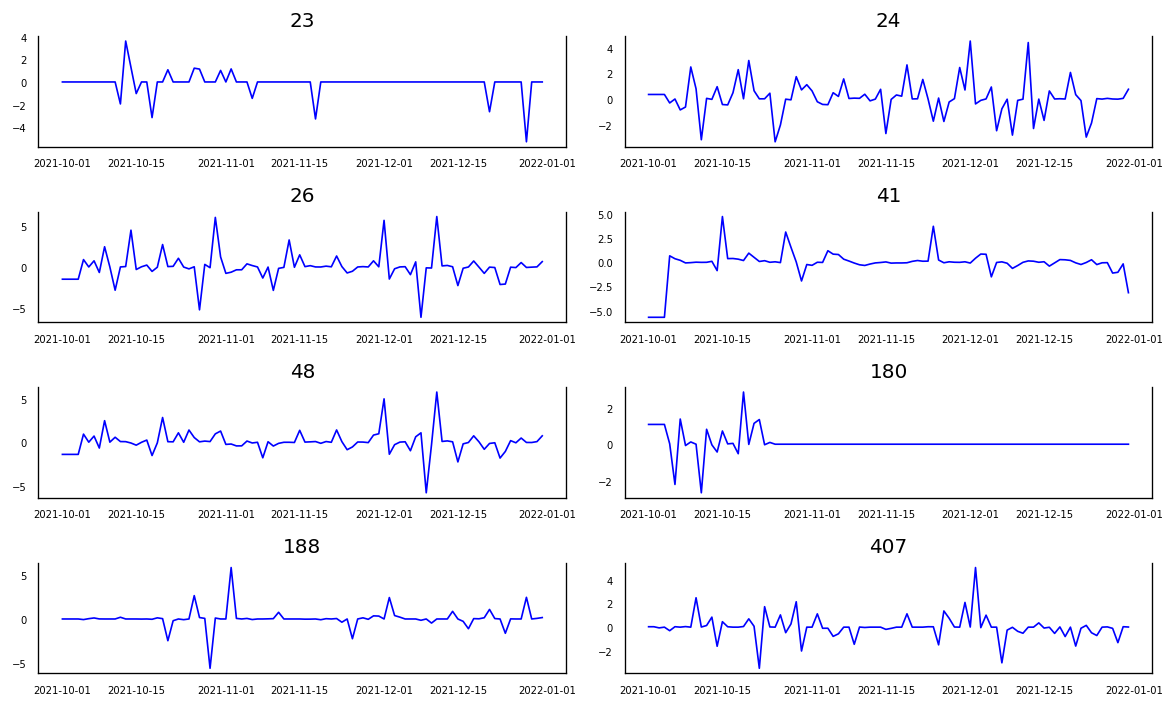

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1676[pivot1676.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(pivot1676.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [34]:
for name, column in pivot1676.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7866
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5241
 No. Lags Chosen       = 6
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [35]:
cointegration_test(pivot1676)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  342.81    > 179.5199  =>   True
24     ::  229.7     > 143.6691  =>   True
26     ::  148.42    > 111.7797  =>   True
41     ::  106.27    > 83.9383   =>   True
48     ::  72.4      > 60.0627   =>   True
180    ::  48.79     > 40.1749   =>   True
188    ::  31.52     > 24.2761   =>   True
407    ::  16.68     > 12.3212   =>   True
490    ::  5.57      > 4.1296    =>   True


In [36]:

#VAR model on df_pivot
model = VAR(pivot1676)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,-0.8089,-0.5484*,0.4454,-0.7042
1,-0.1960,2.408,0.8304,0.8509
2,0.3511,5.300,1.526,2.340
3,0.5153,7.808,2.125,3.447
4,0.6233,10.26,3.338,4.497
5,0.2784,12.26,4.440,5.094
6,-1.237,13.09,2.951,4.521
7,-3.954,12.71,1.412,2.746
8,-10.53*,8.486,0.1060*,-2.883*


In [37]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:08
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    8.48630
Nobs:                     84.0000    HQIC:                  -2.88331
Log likelihood:           26.3813    FPE:                   0.106048
AIC:                     -10.5262    Det(Omega_mle):     0.000380994
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.300283         0.150130           -2.000           0.045
L1.23         -0.535217         0.247384           -2.164           0.031
L1.24          0.146920         0.204544            0.718           0.473
L1.26          0.

 # PIVOT 2259

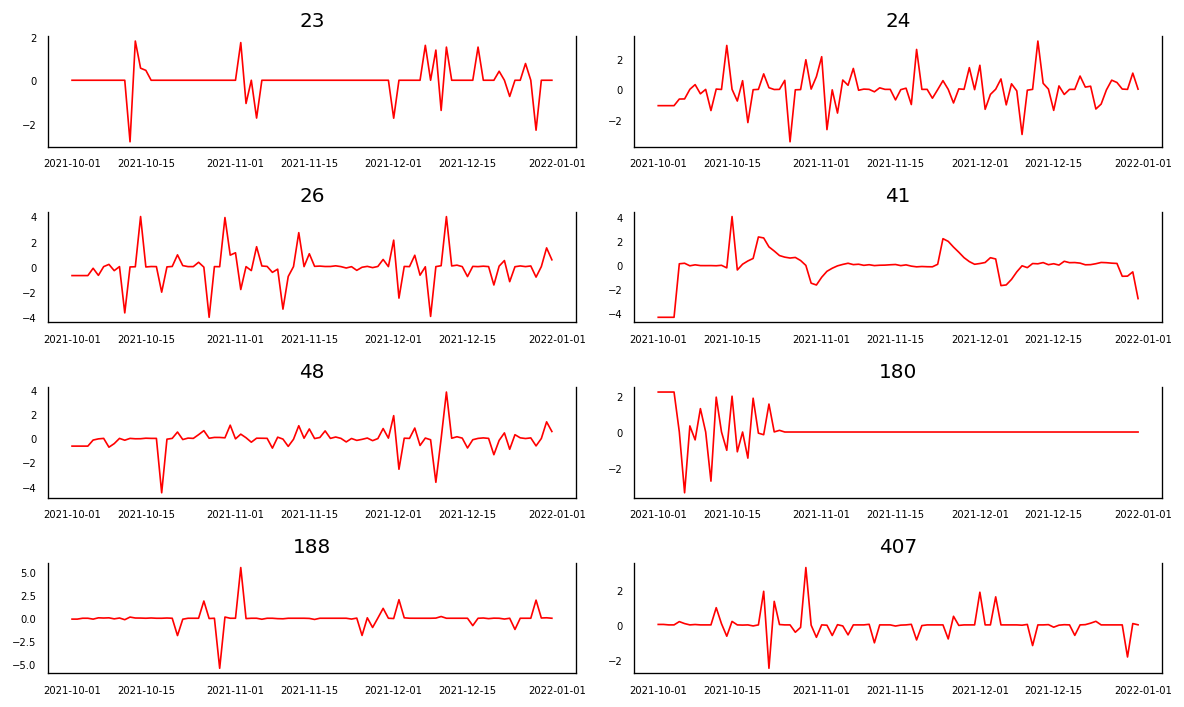

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2259[pivot2259.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2259.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [39]:
 
for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.122
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7205
 No. Lags Chosen       = 5
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [40]:
pivot2259 = pivot2259.diff().dropna()

In [41]:
 
for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.446
 No. Lags Chosen       = 3
 Critical value 1%     = -3.508
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3642
 No. Lags Chosen       = 9
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [42]:
cointegration_test(pivot2259)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  525.28    > 179.5199  =>   True
24     ::  388.92    > 143.6691  =>   True
26     ::  280.18    > 111.7797  =>   True
41     ::  194.23    > 83.9383   =>   True
48     ::  136.92    > 60.0627   =>   True
180    ::  92.76     > 40.1749   =>   True
188    ::  56.81     > 24.2761   =>   True
407    ::  31.98     > 12.3212   =>   True
490    ::  11.44     > 4.1296    =>   True


In [43]:

#VAR model on df_pivot
model = VAR(pivot2259)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,2.572,2.834,13.09,2.677
1,-0.1973,2.425,0.8296,0.8564
2,-1.740,3.243,0.1890,0.2618
3,-2.584,4.760,0.09664,0.3661
4,-3.955,5.749,0.03510,-0.05648
5,-5.468,6.597,0.01493,-0.6213
6,-8.004,6.421,0.003785,-2.209
7,-10.90,5.891,0.001728,-4.151
8,-20.39*,-1.246*,1.014e-05*,-12.70*


In [44]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:15
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -1.24613
Nobs:                     83.0000    HQIC:                  -12.7008
Log likelihood:           443.357    FPE:                1.01428e-05
AIC:                     -20.3929    Det(Omega_mle):     3.46529e-08
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.038557         0.060207           -0.640           0.522
L1.23         -1.237487         0.268706           -4.605           0.000
L1.24          0.297573         0.179546            1.657           0.097
L1.26         -0.

# PIVOT 885

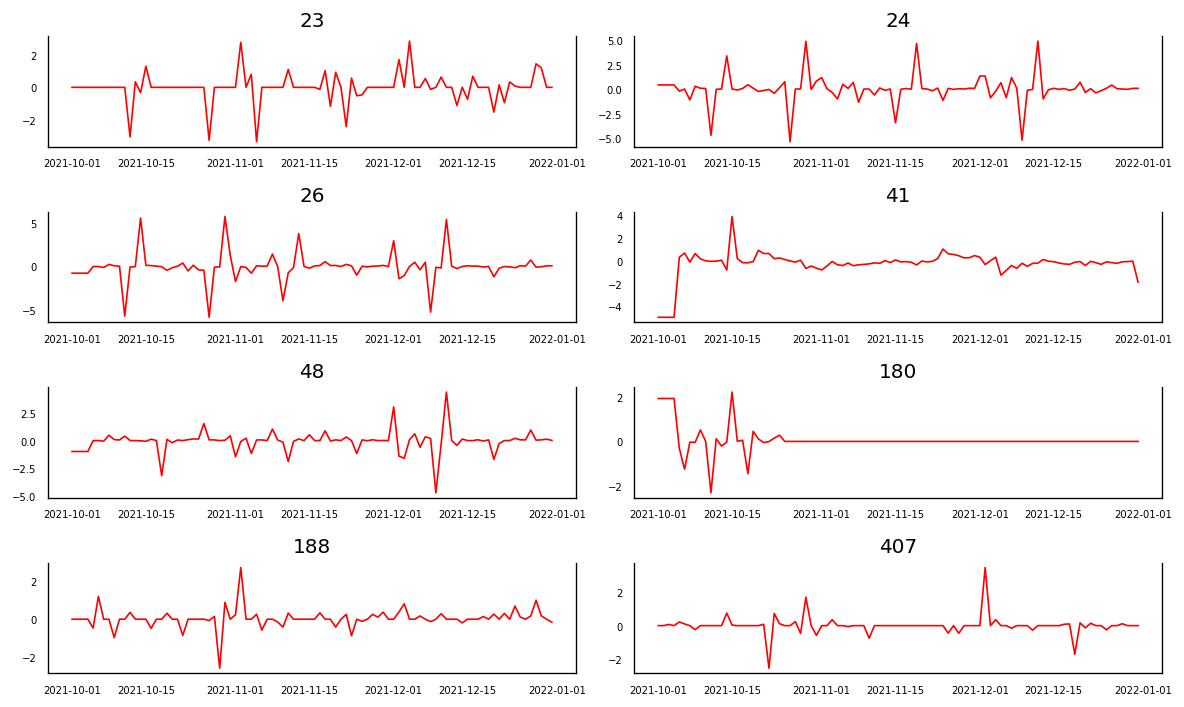

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot885[pivot885.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot885.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [46]:
 
for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.4729
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6504
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [47]:
pivot885 = pivot885.diff().dropna()

In [48]:
 
for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1433
 No. Lags Chosen       = 7
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7865
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [49]:
cointegration_test(pivot885)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  523.58    > 179.5199  =>   True
24     ::  389.34    > 143.6691  =>   True
26     ::  280.64    > 111.7797  =>   True
41     ::  206.71    > 83.9383   =>   True
48     ::  150.17    > 60.0627   =>   True
180    ::  104.28    > 40.1749   =>   True
188    ::  71.84     > 24.2761   =>   True
407    ::  42.48     > 12.3212   =>   True
490    ::  18.2      > 4.1296    =>   True


In [50]:

#VAR model on df_pivot
model = VAR(pivot885)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,0.7710,1.033,2.162,0.8763
1,-1.295,1.328,0.2768,-0.2414
2,-2.803,2.181,0.06533,-0.8006
3,-4.333,3.010,0.01681,-1.383
4,-4.988,4.717,0.01249,-1.089
5,-6.124,5.941,0.007754,-1.277
6,-7.489,6.937,0.006339,-1.693
7,-11.39,5.399,0.001056,-4.644
8,-20.42*,-1.275*,9.859e-06*,-12.73*


In [51]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:20
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -1.27454
Nobs:                     83.0000    HQIC:                  -12.7292
Log likelihood:           444.535    FPE:                9.85876e-06
AIC:                     -20.4213    Det(Omega_mle):     3.36824e-08
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.006382         0.085360            0.075           0.940
L1.23         -0.130810         0.278386           -0.470           0.638
L1.24         -0.076125         0.272076           -0.280           0.780
L1.26         -0.

# PIVOT 2880

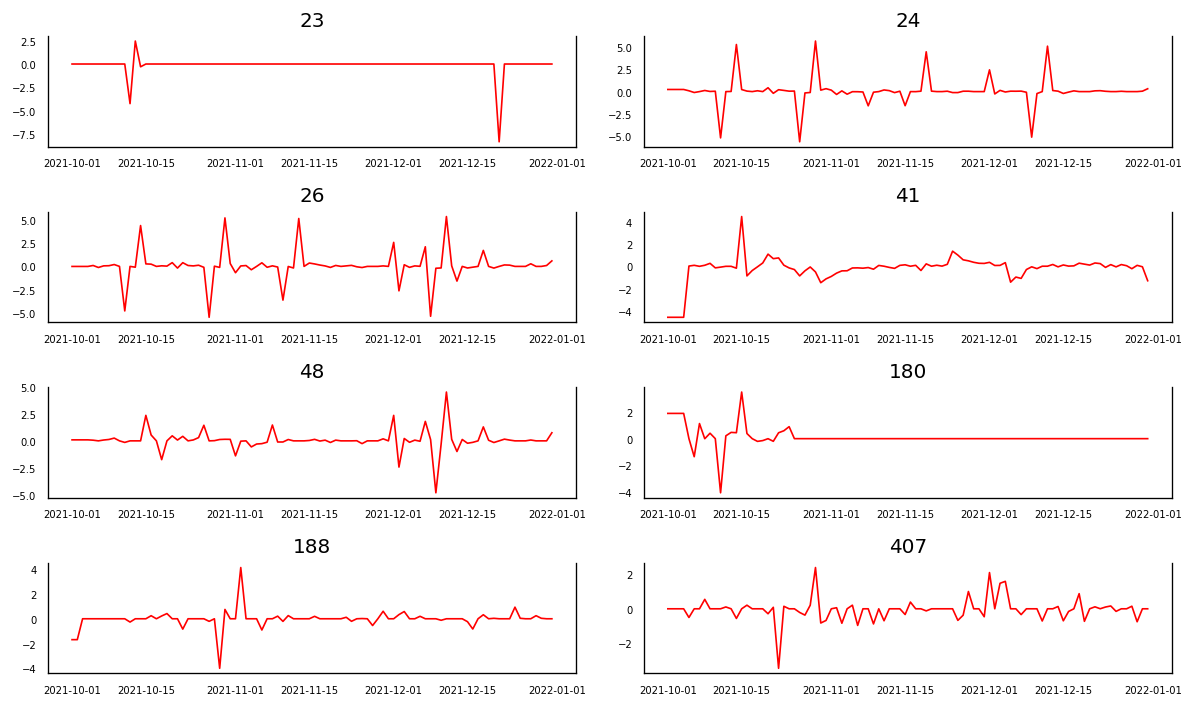

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2880[pivot2880.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2880.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [53]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.7938
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6899
 No. Lags Chosen       = 5
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [54]:
pivot2880 = pivot2880.diff().dropna()

In [55]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.073
 No. Lags Chosen       = 4
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0229
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [56]:
cointegration_test(pivot2880)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  525.28    > 179.5199  =>   True
24     ::  396.0     > 143.6691  =>   True
26     ::  306.36    > 111.7797  =>   True
41     ::  227.59    > 83.9383   =>   True
48     ::  167.16    > 60.0627   =>   True
180    ::  120.49    > 40.1749   =>   True
188    ::  78.93     > 24.2761   =>   True
407    ::  42.91     > 12.3212   =>   True
490    ::  15.23     > 4.1296    =>   True


In [57]:

#VAR model on df_pivot
model = VAR(pivot2880)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,2.563,2.825,12.98,2.669
1,0.6135,3.236,1.867,1.667
2,0.1736,5.157,1.281,2.176
3,0.02632,7.370,1.315,2.977
4,-0.7172,8.987,0.8943,3.181
5,-1.572,10.49,0.7353,3.275
6,-4.037,10.39,0.2000,1.758
7,-9.445,7.341,0.007366,-2.702
8,-21.97*,-2.819*,2.104e-06*,-14.27*


In [58]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:25
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -2.81898
Nobs:                     83.0000    HQIC:                  -14.2736
Log likelihood:           508.630    FPE:                2.10416e-06
AIC:                     -21.9657    Det(Omega_mle):     7.18886e-09
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.019828         0.222710            0.089           0.929
L1.23         -0.817772         0.305738           -2.675           0.007
L1.24          0.252710         0.654273            0.386           0.699
L1.26         -0.

# PIVOT 1127

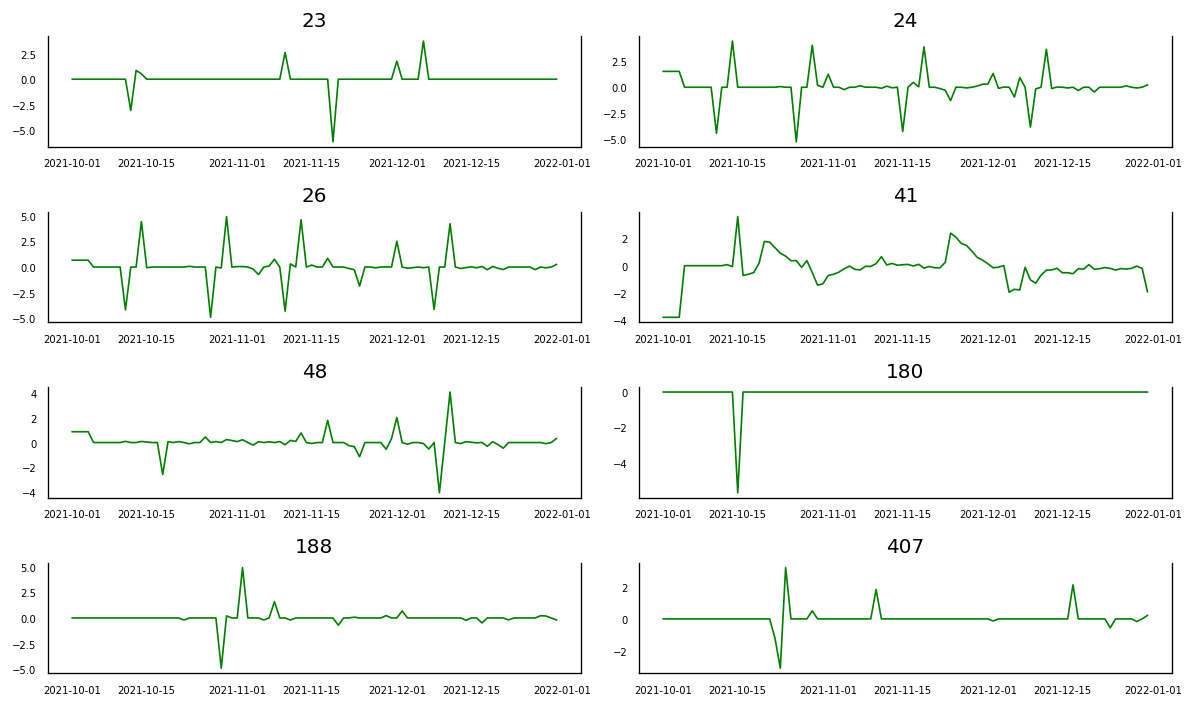

In [59]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1127[pivot1127.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1127.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [60]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.7244
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7437
 No. Lags Chosen       = 6
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [61]:
pivot1127 = pivot1127.diff().dropna()

In [62]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.6128
 No. Lags Chosen       = 3
 Critical value 1%     = -3.508
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.815
 No. Lags Chosen       = 7
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [63]:
cointegration_test(pivot1127)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  514.43    > 179.5199  =>   True
24     ::  385.79    > 143.6691  =>   True
26     ::  289.55    > 111.7797  =>   True
41     ::  214.97    > 83.9383   =>   True
48     ::  152.57    > 60.0627   =>   True
180    ::  101.34    > 40.1749   =>   True
188    ::  58.68     > 24.2761   =>   True
407    ::  30.69     > 12.3212   =>   True
490    ::  8.75      > 4.1296    =>   True


In [64]:

#VAR model on df_pivot
model = VAR(pivot1127)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,2.129,2.391,8.406,2.234
1,0.8406,3.463,2.342,1.894
2,0.1008,5.084,1.191,2.103
3,-0.5727,6.771,0.7224,2.378
4,-0.3402,9.364,1.304,3.559
5,-1.158,10.91,1.112,3.689
6,-3.544,10.88,0.3276,2.252
7,-8.001,8.785,0.03121,-1.258
8,-26.47*,-7.320*,2.336e-08*,-18.77*


In [65]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:30
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -7.31955
Nobs:                     83.0000    HQIC:                  -18.7742
Log likelihood:           695.404    FPE:                2.33617e-08
AIC:                     -26.4663    Det(Omega_mle):     7.98153e-11
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.017007         0.053781           -0.316           0.752
L1.23         -0.238949         0.254362           -0.939           0.348
L1.24          0.320458         0.149077            2.150           0.032
L1.26          0.

# PIVOT 1354

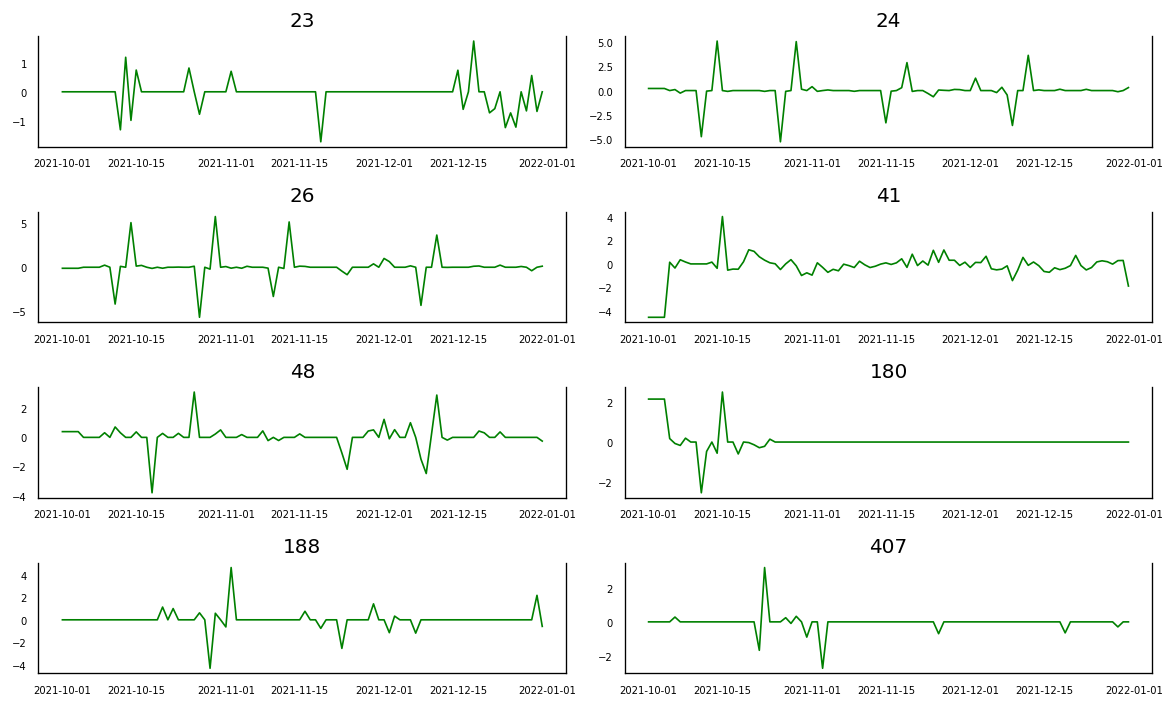

In [66]:

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1354[pivot1354.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1354.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [67]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.8097
 No. Lags Chosen       = 1
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7212
 No. Lags Chosen       = 11
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [68]:
pivot1354 = pivot1354.diff().dropna()

In [69]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8786
 No. Lags Chosen       = 3
 Critical value 1%     = -3.508
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.6886
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [70]:
cointegration_test(pivot1354)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  501.58    > 179.5199  =>   True
24     ::  392.94    > 143.6691  =>   True
26     ::  287.14    > 111.7797  =>   True
41     ::  215.31    > 83.9383   =>   True
48     ::  151.31    > 60.0627   =>   True
180    ::  104.13    > 40.1749   =>   True
188    ::  62.84     > 24.2761   =>   True
407    ::  30.03     > 12.3212   =>   True
490    ::  9.86      > 4.1296    =>   True


In [71]:

#VAR model on df_pivot
model = VAR(pivot1354)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,0.7903,1.053,2.204,0.8957
1,-1.445,1.178,0.2384,-0.3908
2,-2.131,2.852,0.1278,-0.1294
3,-2.615,4.729,0.09376,0.3359
4,-3.181,6.524,0.07612,0.7177
5,-4.218,7.847,0.05213,0.6288
6,-6.350,8.076,0.01980,-0.5542
7,-9.469,7.317,0.007195,-2.725
8,-23.23*,-4.086*,5.924e-07*,-15.54*


In [72]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:35
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -4.08643
Nobs:                     83.0000    HQIC:                  -15.5411
Log likelihood:           561.229    FPE:                5.92423e-07
AIC:                     -23.2332    Det(Omega_mle):     2.02401e-09
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.022210         0.056531           -0.393           0.694
L1.23         -0.818640         0.196310           -4.170           0.000
L1.24         -0.090872         0.203956           -0.446           0.656
L1.26         -0.

# PIVOT 1617

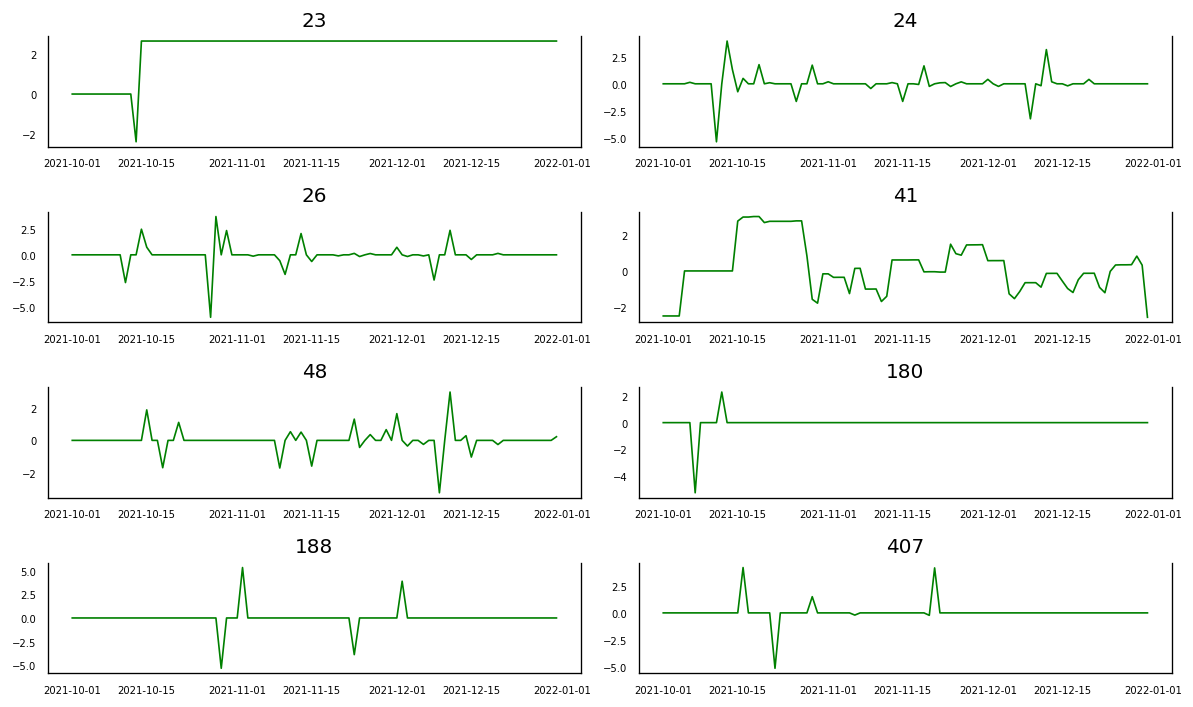

In [73]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1617[pivot1617.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1617.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [74]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6128
 No. Lags Chosen       = 3
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0904. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6129
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significan

In [75]:
pivot1617 = pivot1617.diff().dropna()

In [76]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -14.1695
 No. Lags Chosen       = 0
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.5816
 No. Lags Chosen       = 4
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [77]:
cointegration_test(pivot1617)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  nan       > 179.5199  =>   False
24     ::  420.34    > 143.6691  =>   True
26     ::  288.28    > 111.7797  =>   True
41     ::  198.41    > 83.9383   =>   True
48     ::  139.11    > 60.0627   =>   True
180    ::  98.18     > 40.1749   =>   True
188    ::  58.6      > 24.2761   =>   True
407    ::  27.84     > 12.3212   =>   True
490    ::  4.64      > 4.1296    =>   True


In [78]:

#VAR model on df_pivot
model = VAR(pivot1617)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,-2.335,-2.072,0.09684,-2.229
1,-7.491,-4.868,0.0005641,-6.437
2,-7.750,-2.766,0.0004642,-5.748
3,-8.192,-0.8476,0.0003547,-5.241
4,-44.85,-35.15,6.065e-20,-40.96
5,-139.6,-127.5,8.619e-61,-134.7
6,-141.3,-126.9,4.992e-61,-135.5
7,-143.3,-126.6,5.184e-61,-136.6
8,-150.0*,-130.9*,4.979e-62*,-142.4*


In [79]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:41
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -130.902
Nobs:                     83.0000    HQIC:                  -142.357
Log likelihood:           5824.09    FPE:                4.97906e-62
AIC:                     -150.049    Det(Omega_mle):     1.70110e-64
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.000000         0.000000            0.008           0.994
L1.23          0.191500         0.000000      6175554.411           0.000
L1.24          0.000000         0.000000            0.103           0.918
L1.26          0.

# PIVOT 1776

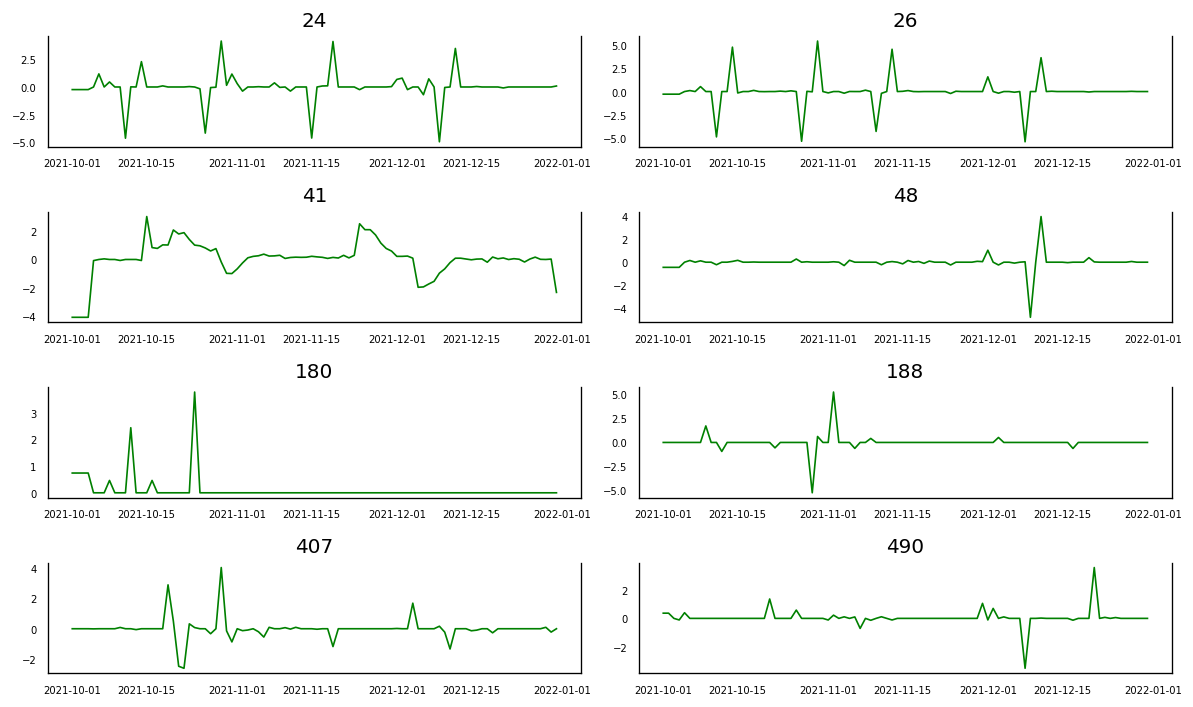

In [80]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1776[pivot1776.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1776.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [81]:
for name, column in pivot1776.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5587
 No. Lags Chosen       = 3
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3568
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [82]:
pivot1776 = pivot1776.diff().dropna()

In [83]:
for name, column in pivot1776.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.7837
 No. Lags Chosen       = 8
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4513
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [84]:
cointegration_test(pivot1776)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  389.91    > 143.6691  =>   True
26     ::  298.45    > 111.7797  =>   True
41     ::  220.84    > 83.9383   =>   True
48     ::  161.61    > 60.0627   =>   True
180    ::  113.62    > 40.1749   =>   True
188    ::  68.26     > 24.2761   =>   True
407    ::  34.6      > 12.3212   =>   True
490    ::  9.85      > 4.1296    =>   True


In [85]:

#VAR model on df_pivot
model = VAR(pivot1776)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,0.6794,0.9125*,1.973,0.7730
1,-0.3535,1.745,0.7071,0.4895
2,-1.543,2.421,0.2241,0.04961
3,-1.856,3.972,0.1823,0.4851
4,-3.140,4.553,0.06270,-0.04957
5,-3.684,5.875,0.05356,0.1560
6,-4.269,7.155,0.05709,0.3206
7,-5.146,8.143,0.06953,0.1924
8,-8.578*,6.576,0.01422*,-2.490*


In [86]:

model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:47
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.08224
Nobs:                     89.0000    HQIC:                 -0.187792
Log likelihood:          -797.717    FPE:                   0.185888
AIC:                     -1.72062    Det(Omega_mle):       0.0459118
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.001192         0.152932            0.008           0.994
L1.24         -0.576266         0.126114           -4.569           0.000
L1.26          0.182438         0.100913            1.808           0.071
L1.41          0.

# PIVOT 624

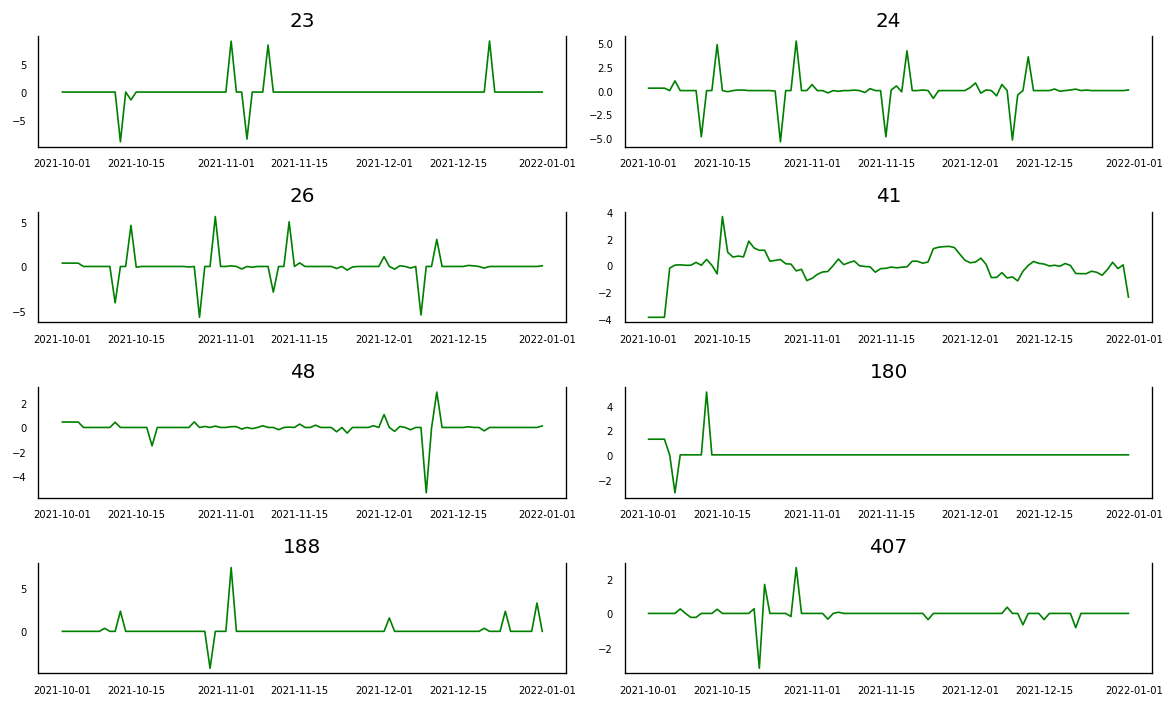

In [87]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot624[pivot624.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot624.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [88]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3036
 No. Lags Chosen       = 3
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6985
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [89]:
pivot624 = pivot624.diff().dropna()

In [90]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8681
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1409
 No. Lags Chosen       = 7
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test S

In [91]:
cointegration_test(pivot624)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  551.02    > 179.5199  =>   True
24     ::  421.9     > 143.6691  =>   True
26     ::  313.23    > 111.7797  =>   True
41     ::  226.34    > 83.9383   =>   True
48     ::  159.46    > 60.0627   =>   True
180    ::  108.06    > 40.1749   =>   True
188    ::  63.16     > 24.2761   =>   True
407    ::  34.68     > 12.3212   =>   True
490    ::  11.41     > 4.1296    =>   True


In [92]:

#VAR model on df_pivot
model = VAR(pivot624)
x = model.select_order(maxlags=8)
x.summary()


,AIC,BIC,FPE,HQIC
0,4.069,4.331,58.47,4.174
1,2.529,5.152,12.67,3.583
2,0.8909,5.874,2.625,2.893
3,0.5379,7.882,2.193,3.488
4,0.7880,10.49,4.029,4.687
5,-0.4953,11.57,2.157,4.352
6,-4.639,9.786,0.1095,1.156
7,-8.749,8.037,0.01477,-2.006
8,-22.53*,-3.378*,1.203e-06*,-14.83*


In [93]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:13:52
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -3.37830
Nobs:                     83.0000    HQIC:                  -14.8329
Log likelihood:           531.842    FPE:                1.20273e-06
AIC:                     -22.5250    Det(Omega_mle):     4.10912e-09
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.022376         0.269440           -0.083           0.934
L1.23         -0.844268         0.354784           -2.380           0.017
L1.24          0.897394         0.751246            1.195           0.232
L1.26         -0.

# Grangers causation coded_cat1

In [94]:
from statsmodels.tsa.stattools import grangercausalitytests

Function build to have the grangers matrix

In [95]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var for var in variables]
        df.index = [var  for var in variables]
        return df

In [96]:
grangers_causation_matrix(pivot1127, variables= pivot1127.columns)

,23,24,26,41,48,180,188,407,490
23,1.0000,0.0313,0.4312,0.2495,0.1947,0.8652,0.5347,0.9868,0.1629
24,0.1346,1.0000,0.0149,0.5652,0.0105,0.3369,0.6408,0.0043,0.3057
26,0.0198,0.0472,1.0000,0.3613,0.0461,0.3460,0.0461,0.0651,0.0480
41,0.0505,0.0036,0.0964,1.0000,0.6625,0.0000,0.5618,0.9044,0.3875
48,0.0181,0.0787,0.0081,0.0644,1.0000,0.0083,0.9244,0.8383,0.0000
180,0.0029,0.0000,0.0011,0.8213,0.9031,1.0000,1.0000,1.0000,1.0000
188,0.5090,0.1043,0.0251,0.5285,0.7439,1.0000,1.0000,0.0107,0.6968
407,0.9964,0.7007,0.9341,0.4483,0.6127,1.0000,0.8339,1.0000,0.8615
490,0.0600,0.7792,0.5435,0.3663,0.5322,1.0000,0.8007,0.9536,1.0000


compute the grangers causalty test for each of the category

In [97]:
for i in pdfourth.coded_cat1.unique():
    globals()['grangers{}'.format(i)] = grangers_causation_matrix(globals()['pivot{}'.format(i)], variables = globals()['pivot{}'.format(i)].columns)

Based on the grangers causation:

In [98]:

print('Accordingly with the grangers causalty test:')

for j in pdfourth.coded_cat1.unique():
    print(f'\n In the category {j}')
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            print(f'Seller {i} is the leader and', globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values ,'followers')
        else:
            print(f'Seller {i} has no follower')


Accordingly with the grangers causalty test:

 In the category 1163
Seller 23 is the leader and [180] followers
Seller 24 is the leader and [ 26  41 180] followers
Seller 26 is the leader and [ 24  48 188] followers
Seller 41 is the leader and [ 48 180] followers
Seller 48 is the leader and [24 41] followers
Seller 180 is the leader and [23 41] followers
Seller 188 is the leader and [26] followers
Seller 407 has no follower
Seller 490 is the leader and [26 48] followers

 In the category 1375
Seller 23 is the leader and [41] followers
Seller 24 is the leader and [ 26  41 188] followers
Seller 26 is the leader and [ 24  48 188] followers
Seller 41 is the leader and [ 48 180] followers
Seller 48 is the leader and [24 26] followers
Seller 180 is the leader and [23 41] followers
Seller 188 is the leader and [26] followers
Seller 407 is the leader and [24] followers
Seller 490 is the leader and [23 48] followers

 In the category 2180
Seller 23 is the leader and [41] followers
Seller 24 is 

Insert the results into a DataFrame: the dataframe show the followers of each seller (leader), on columns, for each category

In [99]:
leader = {}
for j in pdfourth.coded_cat1.unique():
    follower = {}
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            follower[i] = list(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values)
    leader[j] = follower           

matrix = pd.DataFrame(leader).T
matrix

,23,24,26,41,48,180,188,490,407
1163,[180],"[26, 41, 180]","[24, 48, 188]","[48, 180]","[24, 41]","[23, 41]",[26],"[26, 48]",NaN
1375,[41],"[26, 41, 188]","[24, 48, 188]","[48, 180]","[24, 26]","[23, 41]",[26],"[23, 48]",[24]
2180,[41],"[23, 26, 407]","[188, 407]","[48, 180, 490]","[26, 180, 490]","[23, 26, 41, 490]","[24, 26]","[180, 407]","[26, 180]"
1676,[41],[407],"[24, 41, 48, 188, 407, 490]",[180],"[24, 26, 407, 490]",[24],[26],NaN,NaN
2259,"[24, 41]","[23, 188]","[24, 48, 188, 407]","[48, 180, 490]","[26, 490]","[23, 41]","[24, 26, 407]","[41, 180, 407]",[41]
885,"[24, 41]","[23, 41, 490]","[24, 41, 48, 180, 188]","[48, 180]","[24, 26, 490]","[41, 188]","[23, 490]","[23, 48, 407]","[188, 490]"
1127,"[26, 48, 180]","[23, 26, 41, 180]","[24, 48, 180, 188]",NaN,"[24, 26]","[41, 48]",[26],"[26, 48]","[24, 188]"
1354,"[41, 180, 490]","[23, 26, 41, 180]","[24, 41, 180, 188]",[48],"[26, 407]","[23, 26, 41, 48]",[407],"[48, 188]","[24, 26, 48]"
1617,"[41, 48, 407]","[23, 26, 41, 180, 407]","[23, 24, 41, 188]",[180],NaN,"[23, 24]",NaN,[407],"[26, 490]"
2880,[41],[41],"[24, 48, 188, 407]",[180],[26],"[23, 24, 41]",[490],"[41, 180, 188, 407]",NaN


computing the more recurrent follower for each seller, and counting in how many categories is the follower

In [100]:
matrix0 = matrix.fillna(0)
follower_mode = []
for i in matrix0.columns:
    mode=[]
    for j in matrix0.index:
        if matrix0[i][j] != 0:
            for g in range(len(matrix0[i][j])):
                mode.append(matrix0[i][j][g])
    print(f'The more recurrent follower for seller {i} is {max(set(mode), key=mode.count)}, that is a follower in {mode.count(max(set(mode), key=mode.count))} categories')
    follower_mode.append(max(set(mode), key=mode.count))

The more recurrent follower for seller 23 is 41, that is a follower in 8 categories
The more recurrent follower for seller 24 is 41, that is a follower in 9 categories
The more recurrent follower for seller 26 is 188, that is a follower in 12 categories
The more recurrent follower for seller 41 is 180, that is a follower in 9 categories
The more recurrent follower for seller 48 is 26, that is a follower in 8 categories
The more recurrent follower for seller 180 is 41, that is a follower in 10 categories
The more recurrent follower for seller 188 is 26, that is a follower in 7 categories
The more recurrent follower for seller 490 is 48, that is a follower in 7 categories
The more recurrent follower for seller 407 is 26, that is a follower in 4 categories


In [102]:
matrix2 = matrix.append(pd.Series(follower_mode, index=matrix.columns, name='followers mode'))

Adding the percentage of the time a seller is leader and the more reccurrent follower to the dataframe

In [103]:
matrix2

,23,24,26,41,48,180,188,490,407
1163,[180],"[26, 41, 180]","[24, 48, 188]","[48, 180]","[24, 41]","[23, 41]",[26],"[26, 48]",NaN
1375,[41],"[26, 41, 188]","[24, 48, 188]","[48, 180]","[24, 26]","[23, 41]",[26],"[23, 48]",[24]
2180,[41],"[23, 26, 407]","[188, 407]","[48, 180, 490]","[26, 180, 490]","[23, 26, 41, 490]","[24, 26]","[180, 407]","[26, 180]"
1676,[41],[407],"[24, 41, 48, 188, 407, 490]",[180],"[24, 26, 407, 490]",[24],[26],NaN,NaN
2259,"[24, 41]","[23, 188]","[24, 48, 188, 407]","[48, 180, 490]","[26, 490]","[23, 41]","[24, 26, 407]","[41, 180, 407]",[41]
885,"[24, 41]","[23, 41, 490]","[24, 41, 48, 180, 188]","[48, 180]","[24, 26, 490]","[41, 188]","[23, 490]","[23, 48, 407]","[188, 490]"
1127,"[26, 48, 180]","[23, 26, 41, 180]","[24, 48, 180, 188]",NaN,"[24, 26]","[41, 48]",[26],"[26, 48]","[24, 188]"
1354,"[41, 180, 490]","[23, 26, 41, 180]","[24, 41, 180, 188]",[48],"[26, 407]","[23, 26, 41, 48]",[407],"[48, 188]","[24, 26, 48]"
1617,"[41, 48, 407]","[23, 26, 41, 180, 407]","[23, 24, 41, 188]",[180],NaN,"[23, 24]",NaN,[407],"[26, 490]"
2880,[41],[41],"[24, 48, 188, 407]",[180],[26],"[23, 24, 41]",[490],"[41, 180, 188, 407]",NaN


# Plot

Sorting the product based on the number of time the price was changed for that product

In [104]:
pdfourth0 = pdfourth.fillna(0)
pdfourth0['price_change_sign'] = np.where(pdfourth.price_change == 0, 1, 0)
prod_p_var = pdfourth0.groupby(['product_id','coded_cat1'])['price_change_sign'].sum()
prod_p_var = pd.DataFrame(prod_p_var)
prod_p_var.reset_index(inplace=True)
prod_p_var.sort_values('price_change_sign', ascending=False, inplace=True)

In [105]:
prod_p_var[prod_p_var.coded_cat1 == 1127].head(30)

,product_id,coded_cat1,price_change_sign
1342,133528,1127,542
2926,153764,1127,509
2928,153768,1127,485
759,123556,1127,471
2911,153615,1127,470
2343,144707,1127,469
988,128491,1127,462
1601,136631,1127,462
1484,135132,1127,458
1102,130376,1127,454


<AxesSubplot: xlabel='comp_date', ylabel='price'>

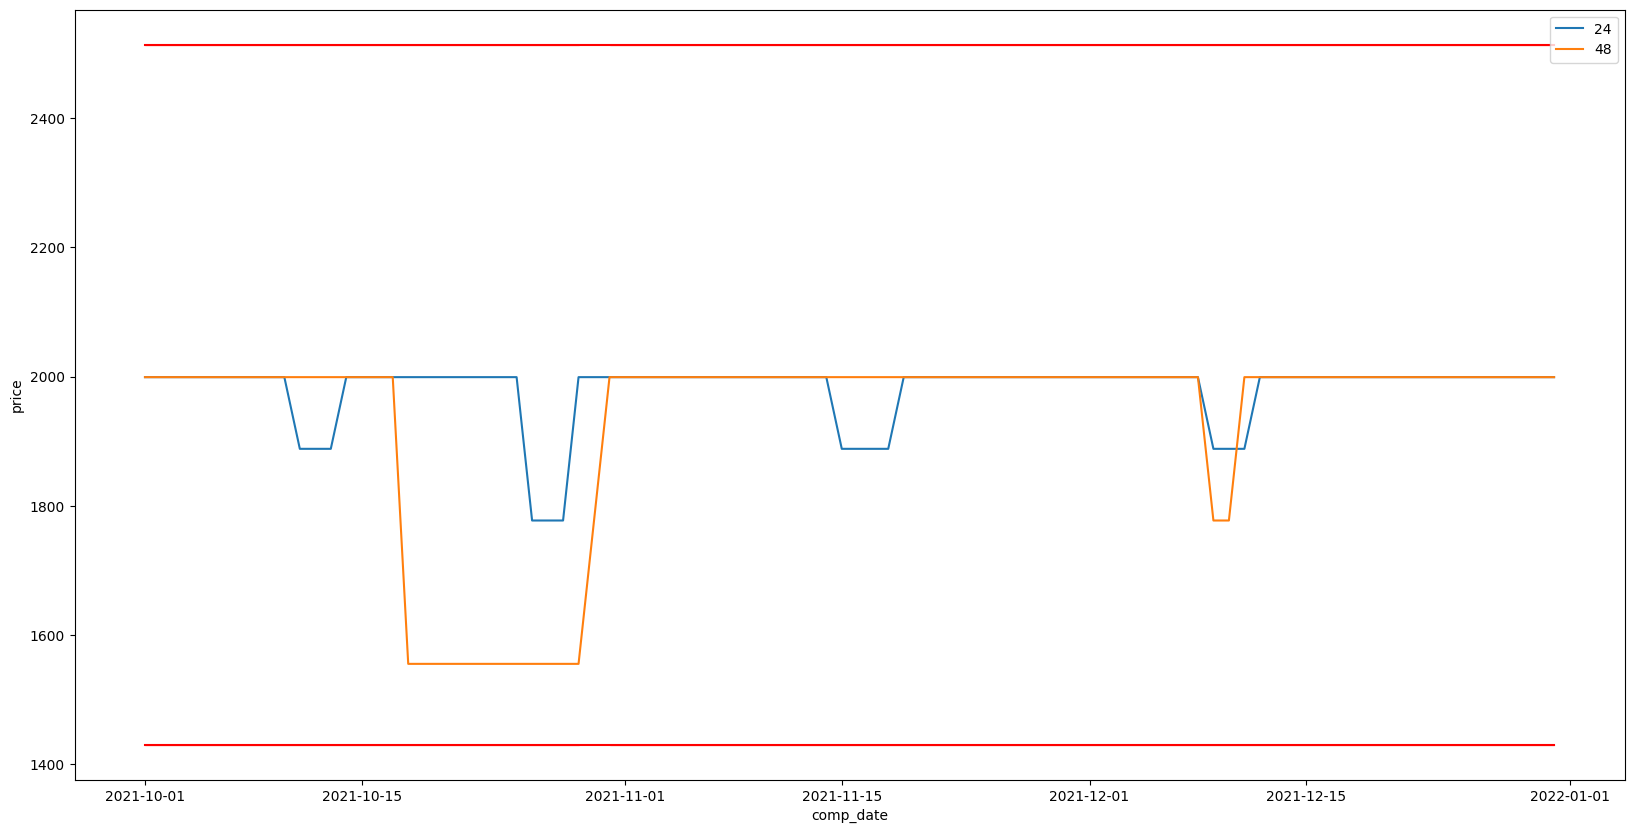

In [106]:
pdfourth['comp_date'] = pd.to_datetime(pdfourth['comp_date'])
plt.figure(figsize=(20,10))
df = pdfourth[(pdfourth.product_id == 161642) & (pdfourth.seller_id.isin([24, 48]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')

<AxesSubplot: xlabel='comp_date', ylabel='price'>

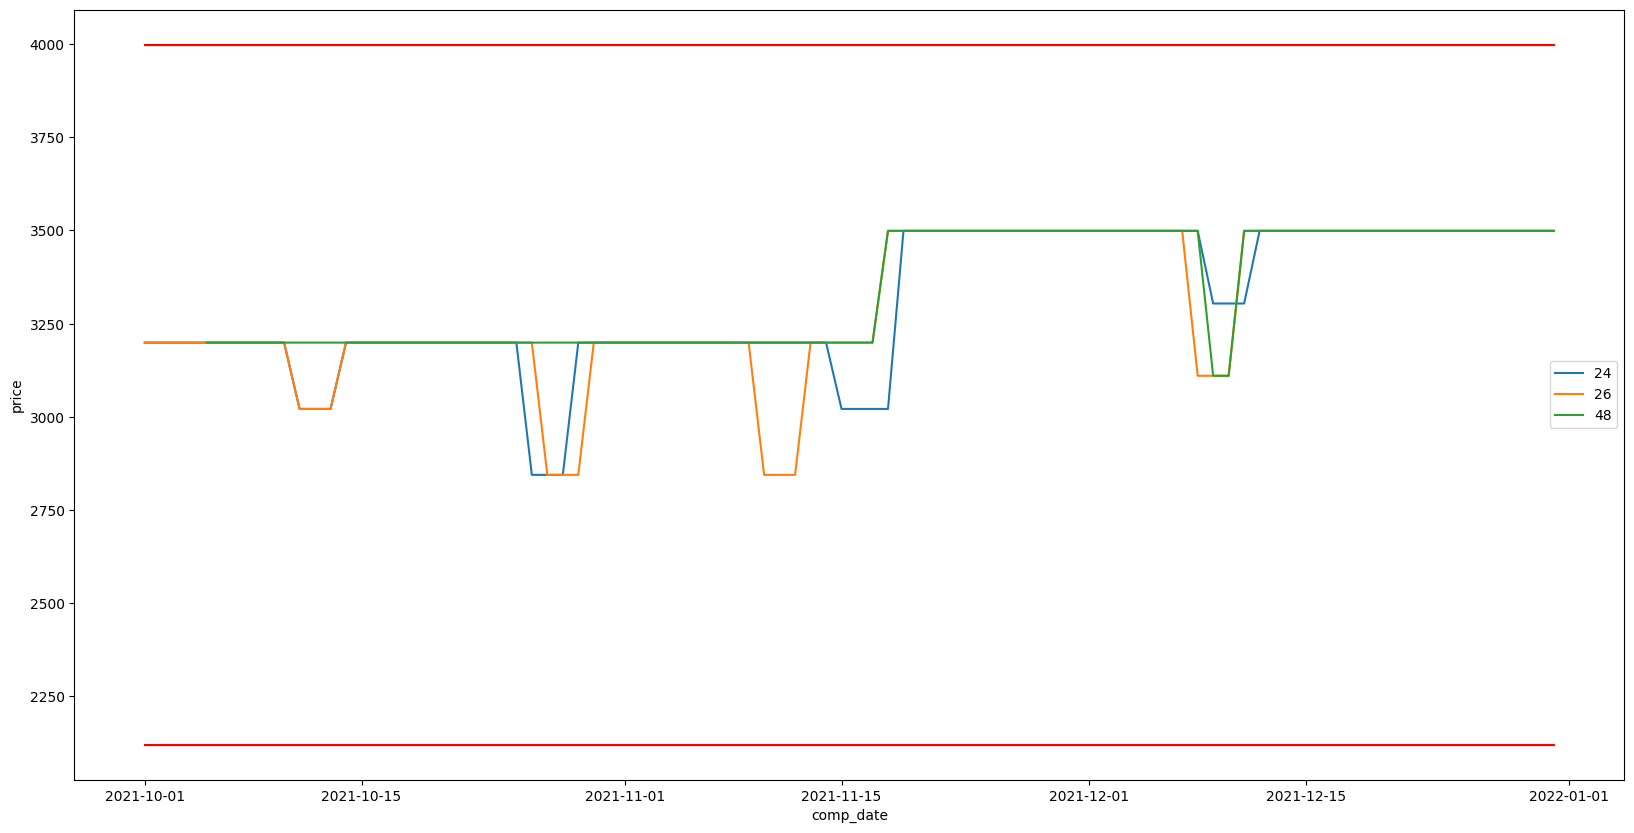

In [107]:
pdfourth['comp_date'] = pd.to_datetime(pdfourth['comp_date'])
plt.figure(figsize=(20,10))
df = pdfourth[(pdfourth.product_id == 132883) & (pdfourth.seller_id.isin([24, 48, 26]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')